Michael Muschitiello // Effective Rank

- This notebook reads multiple Excel sheets containing historical S&P 500 price data for different years, cleans and merges them, then computes an “effective rank” of the covariance matrix of log returns.  
- By examining eigenvalues (through scree plots), the notebook reveals how many independent factors influence the market during each period. Key processes:

1. **Data Input & Cleaning**  
   - Reads each year’s worksheet from an Excel file, drops columns with excessive missing data, and forward/back-fills missing values.

2. **Effective Rank Computation**  
   - Converts prices to log returns, forms a covariance matrix, and computes its eigenvalues.  
   - Normalizes eigenvalues into a probability distribution, calculates Shannon entropy,  
     and exponentiates to get the effective rank (an indicator of dimensionality or factor count).

3. **Scree Plots**  
   - For each year, ranks eigenvalues from largest to smallest  
     and plots them to show which factors dominate market variance.

4. **Use Cases**  
   - Analyzing the evolution of factor concentration year by year.  
   - Identifying periods with higher or lower dimensionality in market relationships.

By computing and visualizing these eigenvalue-based measures, the notebook provides insight  
into how market structure and factor diversity change annually.


In [1]:
import numpy as np 
import pandas as pd 
import math
import yfinance as yf 
import matplotlib.pyplot as plt 
import seaborn as sns 


In [2]:
def read_excel_sheets_to_dfs(file_path):
    """
    Reads all sheets from the given Excel file, returning 
    a dict where each key is a sheet name and each value is a DataFrame.
    If a sheet has a column named 'Unnamed: 0', it's set as the index.
    Columns containing only NaN values are dropped.
    """
    xls = pd.ExcelFile(file_path)
    dfs = {}
    for sheet_name in xls.sheet_names:
        df_temp = pd.read_excel(xls, sheet_name=sheet_name)
        
        # set date col as index
        if "Unnamed: 0" in df_temp.columns:
            df_temp.set_index("Unnamed: 0", inplace=True)

        # drop columns with all nan values
        df_temp.dropna(axis=1, how="all", inplace=True)

        dfs[sheet_name] = df_temp
    return dfs

In [3]:
file_path = "SP500_Hist_Price.xlsx"
dfs = read_excel_sheets_to_dfs(file_path)

In [11]:
tickers_2025 = dfs['2025'].columns.tolist()
data2025 = yf.download(tickers_2025, start="2024-10-24", end="2025-02-24")['Close']
dfs['2025'] = data2025
dfs['2025'].head()

[*********************100%***********************]  499 of 499 completed


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-24,130.448883,230.063660,187.878265,132.750000,115.931625,101.784180,364.230011,482.869995,228.711594,55.972160,...,289.713806,31.931362,97.637451,64.574982,117.563744,130.285217,132.517868,103.766441,362.049988,180.525177
2024-10-25,129.949814,230.901810,186.095093,134.580002,113.623741,100.129616,360.799988,483.720001,229.199524,56.031601,...,289.634033,31.603399,97.727203,63.930325,117.465439,130.055862,132.398438,102.120148,360.089996,179.043167
2024-10-28,131.297302,232.887436,187.907990,135.779999,113.474518,100.471939,361.320007,481.040009,229.169662,56.705246,...,291.299316,31.752474,98.355522,63.950165,116.885437,130.424820,134.209671,103.367340,363.579987,181.778397
2024-10-29,130.987885,233.156845,187.680145,137.779999,112.808022,99.654167,363.040009,485.390015,234.238190,55.793842,...,291.359161,30.689087,98.734497,62.819530,115.292885,129.527344,133.323959,103.646713,384.679993,180.296417
2024-10-30,131.247421,229.594696,199.617569,136.500000,113.852531,99.977470,346.570007,486.679993,229.149734,55.011219,...,292.715363,31.523895,98.225861,62.531910,114.712883,129.856430,132.746765,109.563393,383.890015,181.758514


In [12]:
def print_nonzero_nan_counts(dfs):
    """
    For each (sheet_name, df) pair in dfs,
    prints only the columns that have a non-zero number of NaN values.
    """
    for sheet_name, df in dfs.items():
        print(f"Sheet: {sheet_name}")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            nan_counts = df.isna().sum()
            # only want to see columns with nan vals
            nan_counts = nan_counts[nan_counts > 0]
            if not nan_counts.empty:
                print(nan_counts)
            else:
                print("No columns with NaN values.")
        print("-----------")

print_nonzero_nan_counts(dfs)

Sheet: 2015
REGN    1
VRTX    1
WIN     4
dtype: int64
-----------
Sheet: 2016
No columns with NaN values.
-----------
Sheet: 2017
BCR    1
dtype: int64
-----------
Sheet: 2018
ESRX    6
dtype: int64
-----------
Sheet: 2019
No columns with NaN values.
-----------
Sheet: 2020
BIIB    1
dtype: int64
-----------
Sheet: 2021
KSU    13
dtype: int64
-----------
Sheet: 2022
ABMD    6
dtype: int64
-----------
Sheet: 2023
BIIB     1
SBNY    11
dtype: int64
-----------
Sheet: 2024
CTLT    9
dtype: int64
-----------
Sheet: 2025
No columns with NaN values.
-----------


In [13]:
for sheet_name, df in dfs.items():
    # ID columns with > 15 nan values
    columns_to_drop = [col for col in df.columns if df[col].isna().sum() > 15]
    df.drop(columns=columns_to_drop, inplace=True)
    
    df = df.ffill().bfill()
    #df.fillna(method="ffill", inplace=True)
    #df.fillna(method="bfill", inplace=True)

    print(f"Sheet: {sheet_name}")
    print("Dropped columns:", columns_to_drop)
    print(df.head())
    print("--------------------------------------------------")

Sheet: 2015
Dropped columns: []
                MMM    AES     AFL    GAS    AME        T   ABBV    ABT  \
Unnamed: 0                                                                
2015-01-02  137.166  13.70  30.540  54.63  52.62  25.5643  65.89  44.90   
2015-01-05  134.073  13.31  29.740  53.45  51.04  25.3227  64.65  44.91   
2015-01-06  132.643  13.01  29.475  53.13  50.06  25.3605  64.33  44.40   
2015-01-07  133.605  13.03  29.660  53.82  50.21  25.0359  66.93  44.76   
2015-01-08  136.807  13.23  29.950  54.07  51.45  25.2850  67.63  45.68   

              ACN    ADBE  ...    WEC    WYNN    XEL      XRX    XLNX    XYL  \
Unnamed: 0                 ...                                                 
2015-01-02  88.84  72.340  ...  53.19  146.89  36.12  36.2256  43.600  38.08   
2015-01-05  87.34  71.980  ...  52.54  144.39  35.71  35.4353  42.795  35.71   
2015-01-06  86.71  70.530  ...  52.68  141.31  35.90  34.9610  42.180  35.50   
2015-01-07  88.53  71.110  ...  53.33  145

In [14]:
def print_nonzero_nan_counts(dfs):
    """
    For each (sheet_name, df) pair in dfs,
    prints only the columns that have a non-zero number of NaN values.
    """
    for sheet_name, df in dfs.items():
        print(f"Sheet: {sheet_name}")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            nan_counts = df.isna().sum()
            # filter out cols that have 0 NaN
            nan_counts = nan_counts[nan_counts > 0]
            if not nan_counts.empty:
                print(nan_counts)
            else:
                print("No columns with NaN values.")
        print("-----------")

print_nonzero_nan_counts(dfs)

Sheet: 2015
REGN    1
VRTX    1
WIN     4
dtype: int64
-----------
Sheet: 2016
No columns with NaN values.
-----------
Sheet: 2017
BCR    1
dtype: int64
-----------
Sheet: 2018
ESRX    6
dtype: int64
-----------
Sheet: 2019
No columns with NaN values.
-----------
Sheet: 2020
BIIB    1
dtype: int64
-----------
Sheet: 2021
KSU    13
dtype: int64
-----------
Sheet: 2022
ABMD    6
dtype: int64
-----------
Sheet: 2023
BIIB     1
SBNY    11
dtype: int64
-----------
Sheet: 2024
CTLT    9
dtype: int64
-----------
Sheet: 2025
No columns with NaN values.
-----------


In [15]:
print(f"2015 shape: {dfs['2015'].shape}")
print(f"2016 shape: {dfs['2016'].shape}")
print(f"2017 shape: {dfs['2017'].shape}")
print(f"2018 shape: {dfs['2018'].shape}")
print(f"2019 shape: {dfs['2019'].shape}")
print(f"2020 shape: {dfs['2020'].shape}")
print(f"2021 shape: {dfs['2021'].shape}")
print(f"2022 shape: {dfs['2022'].shape}")
print(f"2023 shape: {dfs['2023'].shape}")
print(f"2024 shape: {dfs['2024'].shape}")
print(f"2025 shape: {dfs['2025'].shape}")


2015 shape: (252, 427)
2016 shape: (252, 433)
2017 shape: (251, 446)
2018 shape: (251, 454)
2019 shape: (252, 465)
2020 shape: (253, 477)
2021 shape: (252, 482)
2022 shape: (251, 479)
2023 shape: (250, 493)
2024 shape: (252, 497)
2025 shape: (81, 499)


Sheet 2015: Effective Rank = 39.2929
Sheet 2016: Effective Rank = 39.6920
Sheet 2017: Effective Rank = 83.6716
Sheet 2018: Effective Rank = 46.9142
Sheet 2019: Effective Rank = 49.9765
Sheet 2020: Effective Rank = 11.4852
Sheet 2021: Effective Rank = 40.8916
Sheet 2022: Effective Rank = 23.1058
Sheet 2023: Effective Rank = 20.0744
Sheet 2024: Effective Rank = 70.1379
Sheet 2025: Effective Rank = 37.0635


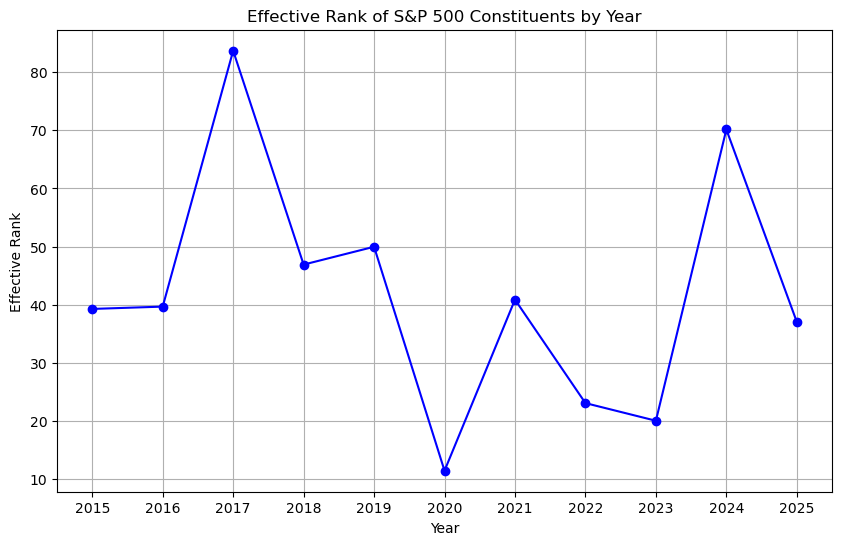

In [16]:
def compute_effective_rank(df):
    """
    Given a DataFrame of daily price data (each column is a constituent and each row a date),
    this function computes the daily log returns of the numeric columns (i.e. prices),
    calculates the covariance matrix of returns, and then computes the effective rank
    via Shannon entropy.
    
    Args:
        df (pd.DataFrame): Daily closing prices (with additional non-numeric columns possible).
        
    Returns:
        effective_rank (float): The effective rank computed as exp(−Σ pᵢ log(pᵢ)).
    """
    import numpy as np
    # only numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    
    # compute log returns
    returns = np.log(df_numeric / df_numeric.shift(1)).dropna()
    
    # covariance matrix
    cov_matrix = returns.cov().to_numpy()
    
    # compute eigenvalues and take the real part
    eigen_vals = np.linalg.eigvals(cov_matrix).real
    
    # normalize eigenvalues into a probability distribution
    total_variance = eigen_vals.sum()
    if total_variance == 0:
        return np.nan
    p = eigen_vals / total_variance
    
    # suppress warnings when taking the log (e.g., for p values equal to 0) NOTE: SUPPRESSING WARNINGS
    with np.errstate(divide='ignore', invalid='ignore'):
        shannon_entropy = -np.sum(np.where(p > 0, p * np.log(p), 0))
    
    # effective rank is the exponential of the shannon entropy
    effective_rank = np.exp(shannon_entropy)
    return effective_rank

for sheet_name, df in dfs.items():
    er = compute_effective_rank(df)
    print(f"Sheet {sheet_name}: Effective Rank = {er:.4f}")

# initialize lists 
sheet_names = []
effective_ranks = []

for sheet_name, df in dfs.items():
    er = compute_effective_rank(df)
    sheet_names.append(sheet_name)
    effective_ranks.append(er)
    
# convert sheet names to integers for proper sorting.
sheets_effective = list(zip(sheet_names, effective_ranks))
sheets_effective_sorted = sorted(sheets_effective, key=lambda x: int(x[0]))
sorted_years, sorted_ers = zip(*sheets_effective_sorted)

# plot effective ranks vs. years.
plt.figure(figsize=(10, 6))
plt.plot(sorted_years, sorted_ers, marker='o', linestyle='-', color='b')
plt.xlabel("Year")
plt.ylabel("Effective Rank")
plt.title("Effective Rank of S&P 500 Constituents by Year")
plt.grid(True)
plt.show()

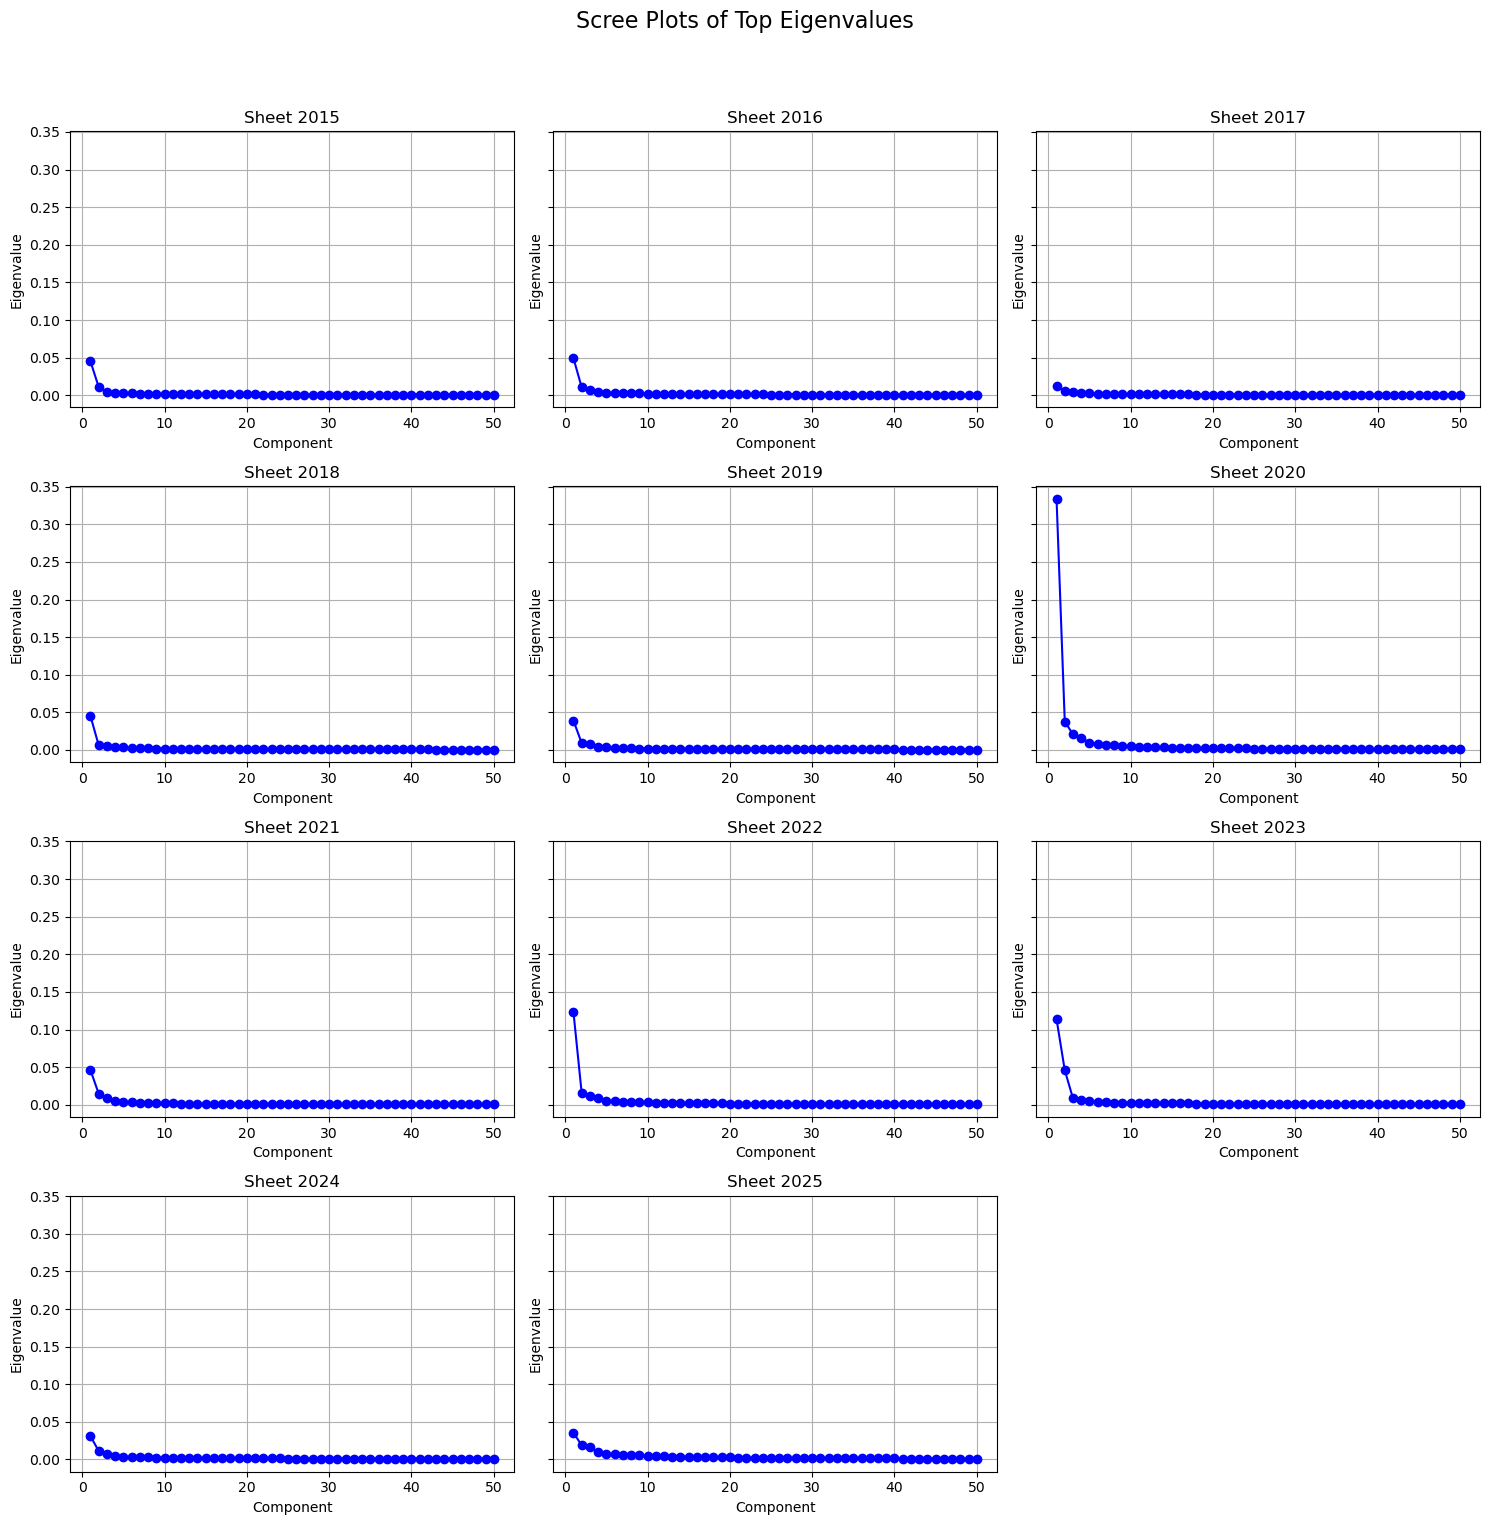

In [18]:
def plot_scree_subplots(dfs, num_components=150, ncols=3):
    """
    For each DataFrame in the input dictionary dfs, this function computes log returns,
    calculates the covariance matrix, performs eigenvalue decomposition,
    and then plots a scree plot of the largest num_components eigenvalues.
    All plots are arranged in a grid of subplots.
    
    Args:
        dfs (dict): Dictionary with sheet names (or years) as keys and DataFrames as values.
        num_components (int): Number of top eigenvalues to plot.
        ncols (int): Number of subplot columns.
    """
    # sort sheets by year
    sorted_sheets = sorted(dfs.items(), key=lambda x: int(x[0]))
    n_sheets = len(sorted_sheets)
    nrows = math.ceil(n_sheets / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), sharey=True)
    axes = np.atleast_2d(axes)  # for indexing
    
    for idx, (sheet_name, df) in enumerate(sorted_sheets):
        # compute log returns using numeric columns only
        df_numeric = df.select_dtypes(include=[np.number])
        returns = np.log(df_numeric / df_numeric.shift(1)).dropna()
        
        # compute covariance matrix and eigen decomposition
        cov_matrix = returns.cov().to_numpy()
        
        # computing eigenvalues
        eigen_vals = np.linalg.eigvals(cov_matrix).real
        eigen_vals_sorted = np.sort(eigen_vals)[::-1]
        
        # only the largest num_components eigenvalues
        eigen_vals_to_plot = eigen_vals_sorted[:min(num_components, len(eigen_vals_sorted))]
        
        row = idx // ncols
        col = idx % ncols
        
        ax = axes[row, col]
        ax.plot(range(1, len(eigen_vals_to_plot)+1), eigen_vals_to_plot, marker='o', linestyle='-', color='b')
        ax.set_title(f"Sheet {sheet_name}")
        ax.set_xlabel("Component")
        ax.set_ylabel("Eigenvalue")
        ax.grid(True)
    
    # clear leftover empty subplots
    total_plots = nrows * ncols
    if total_plots > n_sheets:
        for j in range(n_sheets, total_plots):
            row = j // ncols
            col = j % ncols
            fig.delaxes(axes[row, col])
    
    fig.suptitle("Scree Plots of Top Eigenvalues", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_scree_subplots(dfs, num_components=50, ncols=3)